This script will run the ak and canada models together

Read in packages

In [1]:
import pandas as pd
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.python.lib.io import file_io
from tensorflow.python.keras.optimizer_v2.adam import Adam
import os
import segmentation_models as sm
import matplotlib.pyplot as plt
import numpy as np
#from tensorflow.python.keras.utils.multi_gpu_utils import multi_gpu_model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Dropout,Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.layers import concatenate, Conv2DTranspose, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, Input, AvgPool2D
from tensorflow.keras.models import Model
from keras_unet_collection import models
import tensorflow_addons as tfa
import geopandas as gpd
import logging
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# from tensorflow import tensorflow.keras.mixed_precision.set_global_policy("mixed_float16")

Segmentation Models: using `keras` framework.


/home/spotter5/.conda/envs/deeplearning3/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
/home/spotter5/.conda/envs/deeplearning3/lib/python3.10/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.13.0 and strictly below 2.16.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a 

Image generator for 3 bands

For each year and MTBS/nbac I need to get the year of interest, filter them, then predict my generator on them

In [2]:
min_max_vi = pd.read_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/l8_sent_collection2_global_min_max_cutoff_proj.csv").reset_index(drop = True)
min_max_vi = min_max_vi[['6', '7', '8']]

class img_gen_vi(tensorflow.keras.utils.Sequence):

    """Helper to iterate over the data (as Numpy arrays).
    Inputs are batch size, the image size, the input paths (x) and target paths (y)
    """

    #will need pre defined variables batch_size, img_size, input_img_paths and target_img_paths
    def __init__(self, batch_size, img_size, input_img_paths):
	    self.batch_size = batch_size
	    self.img_size = img_size
	    self.input_img_paths = input_img_paths
	    self.target_img_paths = input_img_paths

    #number of batches the generator is supposed to produceis the length of the paths divided by the batch siize
    def __len__(self):
	    return len(self.input_img_paths) // self.batch_size

    def __getitem__(self, idx):
        
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_img_paths = self.input_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (x)
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size] #for a given index get the input batch pathways (y)
		
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32") #create matrix of zeros which will have the dimension height, wideth, n_bands), 8 is the n_bands
        
  
         #start populating x by enumerating over the input img paths
        for j, path in enumerate(batch_img_paths):

            #load image
            img =  np.round(np.load(path), 3)[:, :, 6:9]

            # img = img * 1000
            img = img.astype(float)
            img = np.round(img, 3)
            img[img == 0] = -999

            img[np.isnan(img)] = -999


            img[img == -999] = np.nan

            in_shape = img.shape
            
            #turn to dataframe to normalize
            img = img.reshape(img.shape[0] * img.shape[1], img.shape[2])
			
            img = pd.DataFrame(img)
			
            img.columns = min_max_vi.columns
			
            img = pd.concat([min_max_vi, img]).reset_index(drop = True)


            #normalize 0 to 1
            img = pd.DataFrame(scaler.fit_transform(img))
			
            img = img.iloc[2:]
#
#             img = img.values.reshape(in_shape)
            img = img.values.reshape(in_shape)

#             replace nan with -1
            img[np.isnan(img)] = -1

#apply standardization
# img = normalize(img, axis=(0,1))

            img = np.round(img, 3)
            #populate x
            x[j] = img#[:, :, 4:] index number is not included, 


        #do tthe same thing for y
        y = np.zeros((self.batch_size,) + self.img_size, dtype="uint8")

        for j, path in enumerate(batch_target_img_paths):

            #load image
            img =  np.round(np.load(path), 3)[:, :, -1]

            img = img.astype(int)

            img[img < 0] = 0
            img[img >1] = 0
            img[~np.isin(img, [0,1])] = 0

            img[np.isnan(img)] = 0
            img = img.astype(int)

            # img =  tf.keras.utils.to_categorical(img, num_classes = 2)
            # y[j] = np.expand_dims(img, 2) 
            y[j] = img
  
       
    #Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
    # y[j] -= 1

        return x, y


In [3]:
#batch size and img size
BATCH_SIZE = 45
GPUS = ["GPU:0", "GPU:1", "GPU:2", "GPU:3"]
strategy = tensorflow.distribute.MirroredStrategy() #can add GPUS here to select specific ones
print('Number of devices: %d' % strategy.num_replicas_in_sync) 

batch_size = BATCH_SIZE * strategy.num_replicas_in_sync

#image size
img_size = (128, 128)

#number of classes to predict
num_classes = 1

# #-------landsat 8
#correct
#"/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/models/nbac_mtbs_regularize_50_global_norm.tf
model_1 = tensorflow.keras.models.load_model("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/models/nbac_mtbs_2019_no_regularize.tf", 
                                           custom_objects={'precision':sm.metrics.Precision(threshold=0.5), 
                                                           'recall':sm.metrics.Recall(threshold = 0.5),
                                                            'f1-score': sm.metrics.FScore(threshold=0.5),
                                                             'iou_score': sm.metrics.IOUScore(threshold=0.5),
                                                              'accuracy': 'accuracy'})


Number of devices: 2


In [4]:
#get all the pathways
training_names = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/mtbs_training_files.csv')['Files'].tolist()
validation_names = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/mtbs_validation_files.csv')['Files'].tolist()
testing_names = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/mtbs_testing_files.csv')['Files'].tolist()

training_names2 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/nbac_training_files.csv')['Files'].tolist()
validation_names2 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/nbac_validation_files.csv')['Files'].tolist()
testing_names2 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/nbac_testing_files.csv')['Files'].tolist()

# #shapefile
in_shape = gpd.read_file('/explore/nobackup/people/spotter5/cnn_mapping/raw_files/ak_mtbs_1985.shp')

in_shape['Year'] = in_shape['Year'].astype(int)


#years to loop through
in_years = range(1985, 2021)


#save all dataframes
final = []
for year in in_years:

    remove = in_shape[in_shape['Year'] .isin ([year])]
    remove.head()

    remove = remove[remove['ID'] .isin (['29690000000000-0000000000', '29690000000000-0000023296']) == False]
    remove['ID'] = remove['ID'].astype(str) + '.npy'

    remove = remove['ID'].tolist()



    def filter_items_by_ending(original_list, unwanted_endings):
        """
        Filters out items from the original list that end with any of the specified unwanted endings.

        Parameters:
        - original_list: List of strings to be filtered.
        - unwanted_endings: List of string endings based on which items will be removed from the original list.

        Returns:
        - List of filtered items not ending with any of the unwanted endings.
        """
        # Use list comprehension to filter out unwanted items
        return [item for item in original_list if not any(item.endswith(ending) for ending in unwanted_endings)]

    training_names = filter_items_by_ending(training_names,remove)
    validation_names = filter_items_by_ending(validation_names,remove)
    testing_names = filter_items_by_ending(testing_names, remove)
    training_names = training_names + testing_names

    def keep_items_by_ending(original_list, wanted_endings):
        """
        Keeps only the items from the original list that end with any of the specified wanted endings.

        Parameters:
        - original_list: List of strings to be filtered.
        - wanted_endings: List of string endings based on which items will be kept in the original list.

        Returns:
        - List of items ending with any of the wanted endings.
        """
        # Use list comprehension to filter and keep wanted items
        return [item for item in original_list if any(item.endswith(ending) for ending in wanted_endings)]

    training_names3 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/mtbs_training_files.csv')['Files'].tolist()
    validation_names3 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/mtbs_validation_files.csv')['Files'].tolist()
    testing_names3 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/mtbs_testing_files.csv')['Files'].tolist()


    training_names3 = keep_items_by_ending(training_names3,remove)
    validation_names3 = keep_items_by_ending(validation_names3,remove)
    testing_names3 = keep_items_by_ending(testing_names3, remove)

    testing_names = training_names3 + validation_names3 + testing_names3



    # #shapefile
    in_shape = gpd.read_file('/explore/nobackup/people/spotter5/cnn_mapping/raw_files/nbac_1985.shp')

    in_shape['Year'] = in_shape['Year'].astype(int)

    remove = in_shape[in_shape['Year'] .isin ([year])]
    remove.head()

    remove = remove[remove['ID'] .isin (['29690000000000-0000000000', '29690000000000-0000023296']) == False]
    remove['ID'] = remove['ID'].astype(str) + '.npy'

    remove = remove['ID'].tolist()


    def filter_items_by_ending(original_list, unwanted_endings):
        """
        Filters out items from the original list that end with any of the specified unwanted endings.

        Parameters:
        - original_list: List of strings to be filtered.
        - unwanted_endings: List of string endings based on which items will be removed from the original list.

        Returns:
        - List of filtered items not ending with any of the unwanted endings.
        """
        # Use list comprehension to filter out unwanted items
        return [item for item in original_list if not any(item.endswith(ending) for ending in unwanted_endings)]

    training_names2 = filter_items_by_ending(training_names2,remove)
    validation_names2 = filter_items_by_ending(validation_names2,remove)
    testing_names2 = filter_items_by_ending(testing_names2, remove)
    training_names2 = training_names2 + testing_names2


    training_names4 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/nbac_training_files.csv')['Files'].tolist()
    validation_names4 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/nbac_validation_files.csv')['Files'].tolist()
    testing_names4 = pd.read_csv('/explore/nobackup/people/spotter5/cnn_mapping/Russia/nbac_testing_files.csv')['Files'].tolist()

    def keep_items_by_ending(original_list, wanted_endings):
        """
        Keeps only the items from the original list that end with any of the specified wanted endings.

        Parameters:
        - original_list: List of strings to be filtered.
        - wanted_endings: List of string endings based on which items will be kept in the original list.

        Returns:
        - List of items ending with any of the wanted endings.
        """
        # Use list comprehension to filter and keep wanted items
        return [item for item in original_list if any(item.endswith(ending) for ending in wanted_endings)]


    training_names4 = keep_items_by_ending(training_names4,remove)
    validation_names4 = keep_items_by_ending(validation_names4,remove)
    testing_names4 = keep_items_by_ending(testing_names4, remove)

    testing_names2 = training_names4 + validation_names4 + testing_names4

    training_names = training_names + training_names2
    validation_names = validation_names + validation_names2
    model_test = testing_names + testing_names2
    
    #make generator
    models_vi_gen =  img_gen_vi(batch_size, img_size, model_test)
    
    if len(models_vi_gen) > 0:
        
        model_1_res = model_1.evaluate_generator(models_vi_gen, 100)

        iou = model_1_res[-2]
        precision = model_1_res[-5]
        recall = model_1_res[-4]
        f1 = model_1_res[-3]
        accuracy = model_1_res[-1]

        # print(f"Model 1 testing IoU is {iou}")
        # print(f"Model 1 testing precision is {precision}")
        # print(f"Model 1 testing recall is {recall}")
        # print(f"Model 1 testing f1 is {f1}")
        # print(f"Model 1 testing accuracy is {accuracy}")
        
        #make new dataframe with scores
        in_df = pd.DataFrame({
            'Year': [year],
            'IOU': [iou],
            'Precision': [precision],
            'Recall': [recall],
            'F-1': [f1],
            'Accuracy': [accuracy]
             }, index=[0]) 

        final.append(in_df)
        
            
final = pd.concat(final).reset_index(drop=True)

final.to_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/yearly_test_metrics.csv", index = False)



/tmp/ipykernel_2482255/1146881939.py:148: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model_1_res = model_1.evaluate_generator(models_vi_gen, 100)


In [6]:
model_test

['/explore/nobackup/people/spotter5/cnn_mapping/Russia/l8_sent_collection2_proj_mtbs_unburned_subs_0_128/0_4_55.npy',
 '/explore/nobackup/people/spotter5/cnn_mapping/Russia/l8_sent_collection2_proj_mtbs_unburned_subs_0_128/16_3_648.npy',
 '/explore/nobackup/people/spotter5/cnn_mapping/Russia/l8_sent_collection2_proj_mtbs_unburned_subs_0_128/6_4_856.npy',
 '/explore/nobackup/people/spotter5/cnn_mapping/Russia/l8_sent_collection2_proj_mtbs_unburned_subs_0_128/3_2_448.npy',
 '/explore/nobackup/people/spotter5/cnn_mapping/Russia/l8_sent_collection2_proj_mtbs_unburned_subs_0_128/3_1_650.npy',
 '/explore/nobackup/people/spotter5/cnn_mapping/Russia/l8_sent_collection2_proj_mtbs_unburned_subs_0_128/12_11_365.npy',
 '/explore/nobackup/people/spotter5/cnn_mapping/Russia/l8_sent_collection2_proj_mtbs_unburned_subs_0_128/2_9_365.npy',
 '/explore/nobackup/people/spotter5/cnn_mapping/Russia/l8_sent_collection2_proj_mtbs_unburned_subs_0_128/9_7_856.npy',
 '/explore/nobackup/people/spotter5/cnn_mappin

In [36]:
# Ensure the DataFrame is sorted by 'Year'
final.sort_values('Year', inplace=True)

# Generate a DataFrame with all years from 1985 to 2020
all_years = pd.DataFrame({'Year': range(1985, 2021)})

# Merge the existing DataFrame with the all_years DataFrame to find missing years
# This uses a left join on the all_years to ensure all years from 1985 to 2020 are included
df_full = pd.merge(all_years, final, on='Year', how='left')

# Calculate the mean of the columns, ignoring NaNs
mean_values = final.mean()

# Fill NaN values in the DataFrame with the mean values of their respective columns
df_full.fillna(mean_values, inplace=True)

# Display the resulting DataFrame
print(df_full)

df_full.to_csv("/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/yearly_test_metrics_filled.csv", index = False)


    Year       IOU  Precision    Recall       F-1  Accuracy
0   1985  0.867519   0.923322  0.934960  0.928778  0.972467
1   1986  0.884518   0.935295  0.941725  0.938202  0.980054
2   1987  0.884518   0.935295  0.941725  0.938202  0.980054
3   1988  0.884518   0.935295  0.941725  0.938202  0.980054
4   1989  0.868682   0.919469  0.940112  0.929385  0.970543
5   1990  0.864921   0.905428  0.950769  0.927267  0.965259
6   1991  0.858239   0.905118  0.943174  0.923418  0.970348
7   1992  0.886895   0.934922  0.945092  0.939730  0.978930
8   1993  0.917387   0.950427  0.963279  0.956761  0.980988
9   1994  0.881008   0.926551  0.947134  0.936456  0.978101
10  1995  0.896817   0.939019  0.952092  0.945350  0.980470
11  1996  0.854106   0.923830  0.918763  0.920974  0.982149
12  1997  0.823534   0.903988  0.901677  0.902374  0.976479
13  1998  0.896074   0.941557  0.948746  0.945001  0.982744
14  1999  0.872201   0.930476  0.932859  0.931505  0.979057
15  2000  0.852916   0.925200  0.915845 

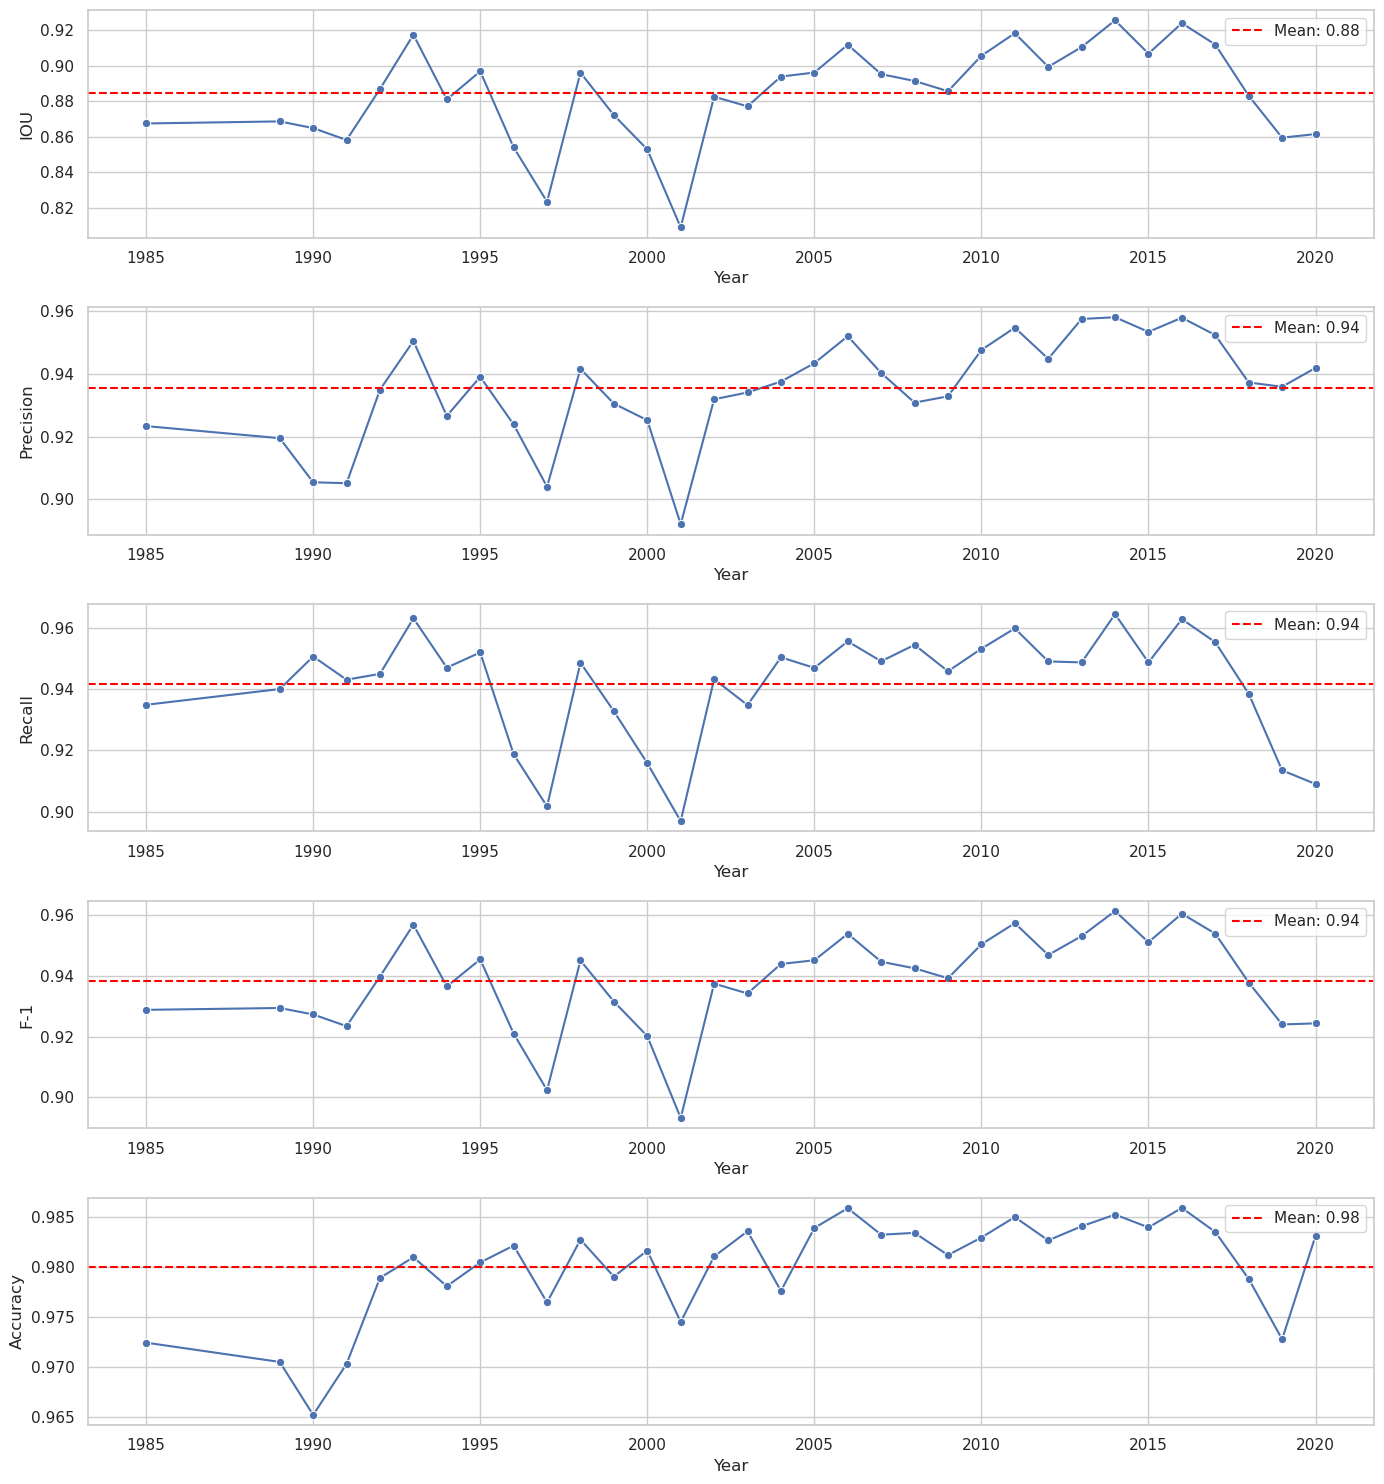

In [46]:
import seaborn as sns

# Setting the aesthetics for the plots
sns.set_theme(style="whitegrid")

# Create a list of the metric columns (excluding 'Year')
metric_columns = final.columns[1:]

# Correcting the subplot index issue in the loop

plt.figure(figsize=(14, 15))

for i, metric in enumerate(metric_columns):
    ax = plt.subplot(len(metric_columns), 1, i + 1)  # Corrected index to start from 1
    sns.lineplot(data=final, x='Year', y=metric, marker='o', sort=False)
    mean_value = final[metric].mean()
    ax.axhline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
    # ax.set_title(metric)
    ax.set_xlabel('Year')
    ax.set_ylabel(metric)
    ax.legend()

plt.tight_layout()

save_path = '/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/temporal_metrics.png'
plt.savefig(save_path)
plt.show()



In [41]:
print(final['IOU'].min(), final['IOU'].max())

0.809145987033844 0.925479531288147


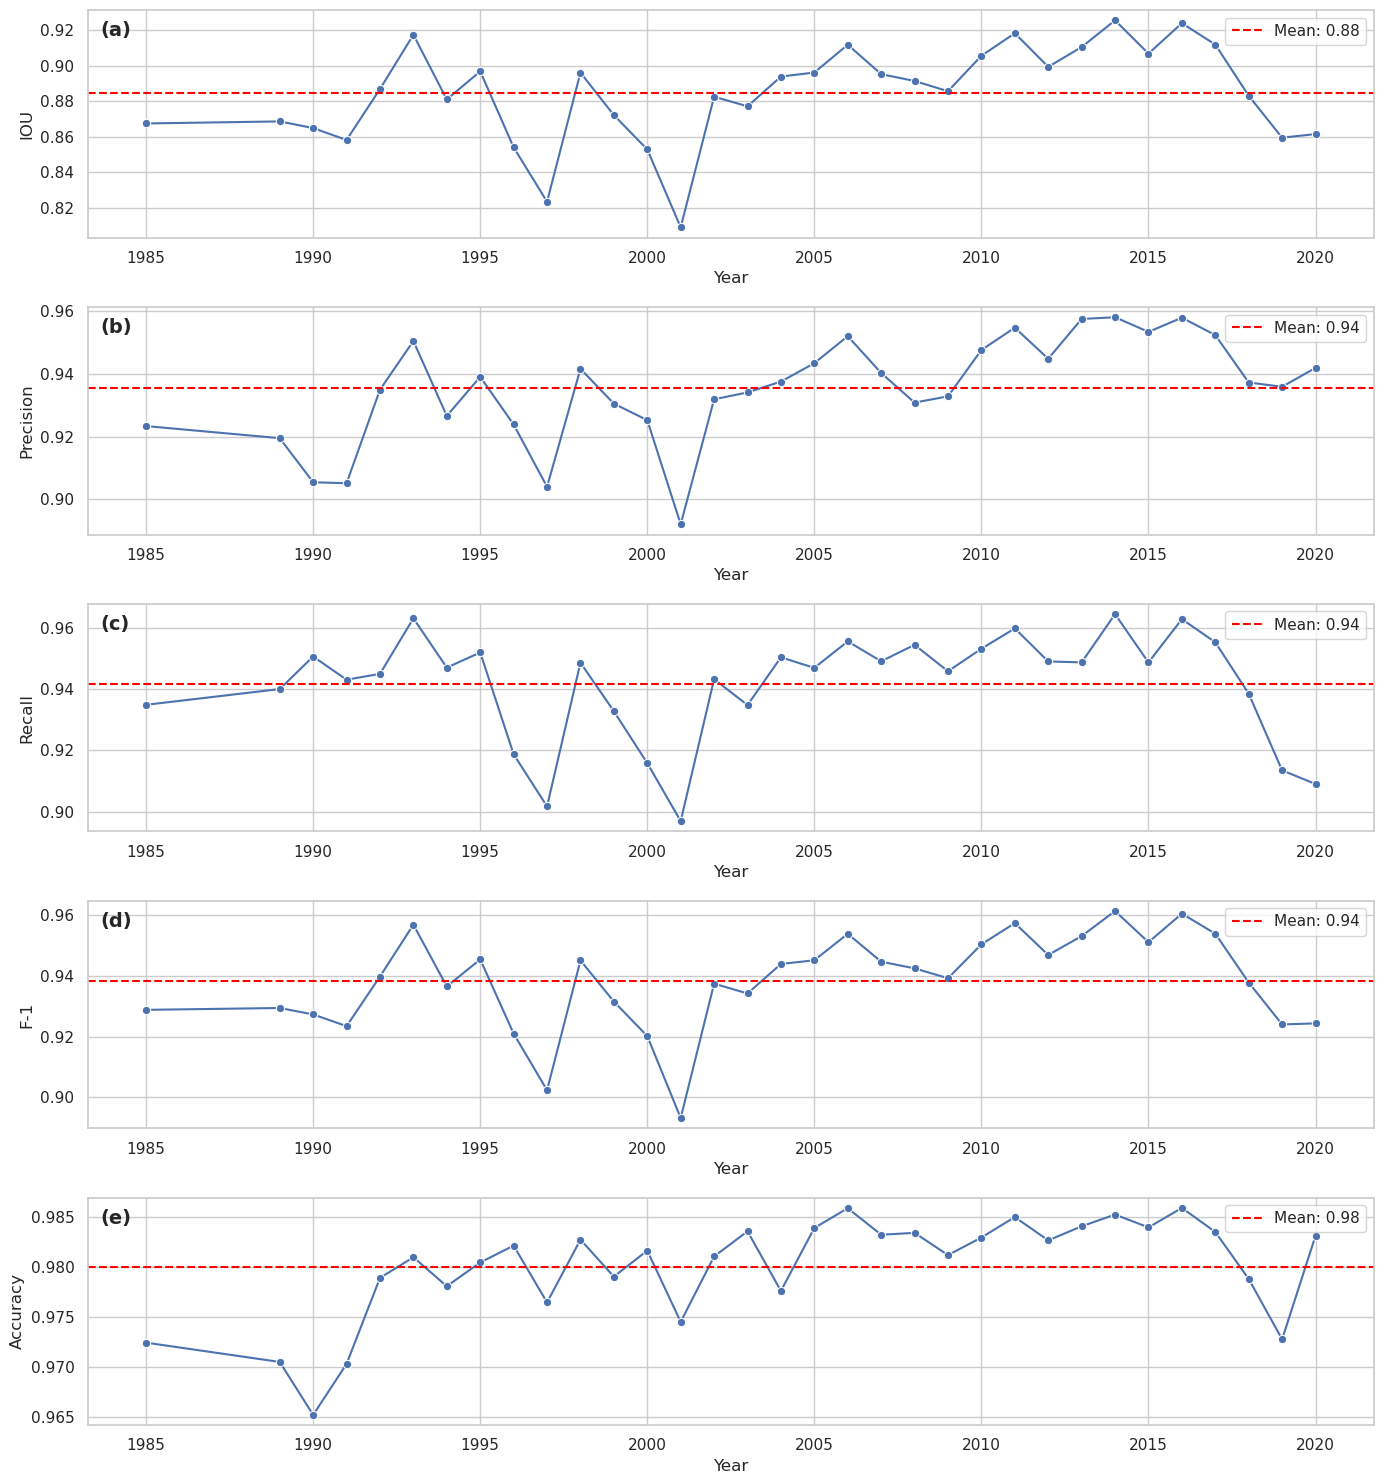

In [48]:
fig, axes = plt.subplots(len(metric_columns), 1, figsize=(14, 15))
letters = ['(a)', '(b)', '(c)', '(d)', '(e)']  # Letters to indicate the plot

for i, metric in enumerate(metric_columns):
    sns.lineplot(ax=axes[i], data=final, x='Year', y=metric, marker='o', sort=False)
    mean_value = final[metric].mean()
    axes[i].axhline(mean_value, color='red', linestyle='--', label=f'Mean: {mean_value:.2f}')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel(metric)
    axes[i].legend()
    axes[i].text(0.01, 0.95, letters[i], transform=axes[i].transAxes, 
                 fontsize=14, fontweight='bold', va='top')

plt.tight_layout()


save_path = '/explore/nobackup/people/spotter5/cnn_mapping/nbac_training/area_comparisons/temporal_metrics.png'
plt.savefig(save_path)
plt.show()



In [42]:
print(final['IOU'].mean())

0.8845178882280985
